Copyright &copy; 2022 Luis Cano. Subject to the **KALIK Software License Agreement** license.

This file is part of **KALIK** project which is released under **KALIK Software License Agreement**.

See file **LICENSE.txt** or go to https://github.com/CAMAY3101/KALIK/blob/main/LICENSE.md for full license details.

# Model Long Forecast

Model specialized at making longer forecasts, using each day's financial values forecast as input for the next day's forecast.

## Import Libraries

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Create Models

Sentiment Analysis Model. Includes vocabulary embedding, LSTM layers, Linear layers and SELU activation function.

In [133]:
class SentientAnalizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_dim):
        super(SentientAnalizer, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.Vocab_Embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=2, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self,x, hidden):
        emb = self.Vocab_Embedding(x).view(x.shape[0],x.shape[1],-1)
        #print (emb.shape)
        #print (hidden[0].shape)
        out, hidden = self.LSTM(emb, hidden)
        out = self.Linear1(out)
        out = torch.selu(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

Stock Price Prediction Model. Includes attention layer to understand the context of the variables, LSTM layers, Linear layers, Dropout layer and SELU activation function. Takes 9 variables and the sentiment output as inputs, and outputs the 9 variables for the next step (next day).

In [134]:
class StockPredictor(nn.Module):

    def __init__(self, input_size_stock,input_size_sentiment, hidden_size, num_layers, max_length):
        super(StockPredictor, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size_stock = input_size_stock
        self.input_size_sentiment = input_size_sentiment
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn_hidd = nn.Linear(self.input_size_stock, max_length)
        self.attn_out = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.CombinedLayerSS = nn.Linear(self.input_size_stock+self.input_size_sentiment, self.hidden_size)
        self.LSTM = nn.LSTM(self.input_size_sentiment+self.input_size_stock, self.hidden_size,num_layers=num_layers, batch_first=False)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.Linear2 = nn.Linear(self.hidden_size, self.input_size_stock)


    def forward(self,x, hidden, stock_news):
        #print ("hidden:",hidden[0][0].shape)
        attn_wights = F.softmax(self.attn_hidd(x), dim=1)
        #print (attn_wights.shape, stock_news.shape)
        context = torch.bmm(attn_wights, stock_news)
        #context = torch.einsum('ij,ijk->ik', attn_wights, stock_news)
        #print (context.shape, x.shape)
        x_SS = torch.cat((x,context),dim=2)
        out, hidden = self.LSTM(x_SS, hidden)
        out = self.Linear1(out)
        out = torch.selu(out)
        out = self.dropout(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

## Load Data

In [135]:
news_1 = pd.read_csv('../data/Preprocess/final_data/Crypto_Currency_News.csv') # news_np[0]
news_2 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrencies.csv') # news_np[1]
news_3 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrency.csv') # news_np[2]
news_4 = pd.read_csv('../data/Preprocess/final_data/Cryptomarkets.csv') # news_np[3]
news_5 = pd.read_csv('../data/Preprocess/final_data/eth.csv') # news_np[4]
news_6 = pd.read_csv('../data/Preprocess/final_data/ethfinance.csv') # news_np[5]
news_7 = pd.read_csv('../data/Preprocess/final_data/ethtrader.csv') # news_np[6]

stocks_std = pd.read_csv('../data/Preprocess/final_data/finance_std.csv')


news_dfs = [news_1, news_2, news_3, news_4, news_5, news_6, news_7]
col_names = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']

# import mean and std used to standardize the data
with open('../data/Preprocess/means_stds.pkl', 'rb') as f:
    means, stds = pkl.load(f)

##### Reshape & Transform data to numpy

In [136]:
'''
example of cell in news_1:
'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]'
is saved as a string
'''
# change type
import ast
for df in news_dfs:
    for j in range(1,11):        
        df['tok_text_'+str(j)] = np.array(df['tok_text_'+str(j)].apply(lambda x: ast.literal_eval (x)))

In [137]:
# convert all dataframes to numpy
# news_1_np = news_1.to_numpy()
news_np = []
for df in news_dfs:
    news_np.append(df.to_numpy())

stocks_std_np = stocks_std.to_numpy()

# delete 1st column
# news_1_np = news_1_np[:,1:]
for i in range(len(news_np)):
    news_np[i] = np.delete(news_np[i], 0, 1)
stocks_std_np = stocks_std_np[:,1:]

# reshape from (n,10) lists to (n,10,15) numbers
for k in range(len(news_np)):
    news_np[k] = np.array([np.array([np.array(news_np[k][i][j]) for j in range(10)]) for i in range(news_np[k].shape[0])])

# print
for i in range(len(news_np)):
    print(news_np[i].shape)
print (stocks_std_np.shape)
# print first row, already checked it is the first row from the CSVs
# print (news_np[0][0])
# print(stocks_norm_np[0])

(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 9)


##### Make dataset
Data is split in 1089 days for training, which will be split in four 256 day batches and one 64 day batch, and 7 extra days for testing.

In [138]:
# shape dataset to pytorch dataset class    
class Dataset (torch.utils.data.Dataset):
    def __init__(self, data_stock, notice, target):
        self.data = data_stock.unsqueeze(1)
        self.notice = notice.unsqueeze(3)
        self.target = target.unsqueeze(1)
        # Standardize data
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.target = (self.target - self.target.mean()) / self.target.std()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.notice[idx], self.target[idx]

# split dataset into train and test
# using news_1 and stocks_norm, use all except one week, we will predict this week in testing
# data_stock = torch.Tensor(stocks_norm_np[:,:]).float()
data_stock = torch.Tensor(stocks_std_np[:-7,:].astype(np.float32))
test_stock = data_stock[-1] # we will start forcast from the real value of the last day of the train set
test_stock = test_stock.unsqueeze(0).unsqueeze(0)
# data_news = torch.Tensor(news_np[0]).long() 
data_news = torch.Tensor(news_np[0][:-7,:,:]).long() # news_np[0] is news_1 (Crypto_Currency_News.csv), change to others as needed
target = data_stock[1:,:]
data_stock = data_stock[:-1,:]
print (data_stock.shape, data_news.shape, target.shape)

# create dataset
dataset = Dataset(data_stock, data_news, target)

torch.Size([1088, 9]) torch.Size([1089, 10, 15]) torch.Size([1088, 9])


## Start Model

In [57]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [139]:
Senti = SentientAnalizer(1, 128, 256, 50000, 128) # .to(device) # 50000 is the size of the vocabulary, our dictionary has 49783 words
Stock = StockPredictor(9,256,256,4,10) # .to(device) # 9 is the number of variables in the stock

Define the batch size we will use, 256 makes 5 batches.

1088 - (256*4) = 64, which will be the size of the fifth batch.

In [140]:
# dataloader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

future is the number of days we want to predict per batch during training.

In [141]:
# optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.001) # lr=0.001
# loss function
criterion = nn.MSELoss()
# clip gradient
clip = .5
# future
future = 50

## Train Model

Unlike the short forecast scenario, we want to specialize this model at working with longer forecasts and not just short term one week predictions. 

So we divide the data in 256 days batches (5 total, last batch with the remainder) from which 50 will be "future" days. We train the Stock model passing the first 206 senti_outputs and stock_data of a batch in a single instance and then for the last 50 days make predictions using previous stock ouput and stock hidden as input of next day.

This way the model learns how to work with the hidden state memory and outputs as next inputs when doing forecasts during training. So when making real forecasts it should have a better idea of what to do.

After each set of batches we regularize the gradients by clipping to avoid exploding gradients.

In [61]:
# train
epochs = 140
for epoch in range(epochs):
    
    
    #hidde_stock = (hidde_stock[0][:,:-future], hidde_stock[1][:,:-future])
    tot_loss = 0
    mean_loss = 0
    Progressbar = tqdm(train_loader)
    for i, (data_stock,data_news,target) in enumerate(Progressbar):
        #print (data_stock.shape, data_news.shape, target.shape)
        hidde_senti = Senti.init_hidden(10)
        hidde_senti = (hidde_senti[0], hidde_senti[1]) # (hidde_senti[0].to(device), hidde_senti[1].to(device))
        hidde_stock = Stock.init_hidden(batch_size=1)
        hidde_stock = (hidde_stock[0], hidde_stock[1]) # (hidde_stock[0].to(device), hidde_stock[1].to(device))
        data_stock = data_stock
        data_news = data_news
        target = target
        senti_outputs = []
        stock_outputs = []
        for batch in data_news:
            senti_output, hidden_senti = Senti(batch.squeeze(0), hidde_senti)
            senti_outputs.append(senti_output[:,-1,:])
        senti_outputs = torch.cat(senti_outputs, dim=0)    
        senti_outputs = senti_outputs.reshape(len(data_stock),10,256)
        #print (data_stock.shape)
        #print (senti_outputs.shape)
        #print (hidde_stock[0].shape)
        #print (hidde_stock[1].shape)
        # if we are in the last batch
        if i == len(train_loader)-1:
            future = 32
        data_stock = data_stock[:-future]
        stock_output, hidde_stock = Stock(data_stock, hidde_stock, senti_outputs[:-future])
        #print ("output",stock_output.shape)
        output = stock_output[-1,:,:]
        senti = senti_outputs[-future,:,:]
        #print (output.shape)
        #print (hidde_stock[0].shape)
        for i in range(future):
            #print ("Sizes:",output.shape, senti.shape, hidde_stock[0].shape)
            output, hidde_stock = Stock(output.unsqueeze(0), hidde_stock, senti.unsqueeze(0))
            stock_outputs.append(output)
            output = output.squeeze(0)
            #print (output.shape)
        stock_outputs = torch.cat(stock_outputs, dim=0)
        # cat stock_output and stock_outputs
        stock_output = torch.cat((stock_output, stock_outputs), dim=0)
        #print (stock_output.shape)
        loss = criterion(stock_output, target)
        mean_loss += loss
        Progressbar.set_description("Epoch: {}, Loss: {}".format(epoch, mean_loss.item()/len(train_loader)))
    mean_loss = mean_loss/len(train_loader)
    mean_loss = mean_loss #.cpu()
    optimizer.zero_grad()
    mean_loss.backward()
    torch.nn.utils.clip_grad_norm_(list(Senti.parameters())+list(Stock.parameters()), clip)
    optimizer.step()
    if (epoch+1)%4 == 0:
        print ("Epoch: {}/{}...".format(epoch+1, epochs),
               "Loss: {:.6f}...".format(mean_loss.item()))
        

Epoch: 0, Loss: 0.9511863708496093: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


KeyboardInterrupt: 

## Save model

In [34]:
# Save model
torch.save(Senti.state_dict(), 'saved_models_L/SentiF_30_02.pt')
torch.save(Stock.state_dict(), 'saved_models_L/StockF_30_02.pt')

## Load and Test Model

If model was trained with GPU and now want to run it in CPU (my case) use: map_location=torch.device('cpu').
The oposite of this: map_location = torch.device('cuda:device_id')

In [142]:
# Load model
Senti.load_state_dict(torch.load('saved_models_L/SentiL_30_01.pt', map_location=torch.device('cpu')))
Stock.load_state_dict(torch.load('saved_models_L/StockL_30_01.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

## Test Predictions & Forecast

Using torch.no_grad() make all predictions with future forecasts for the 5 batches of the model.

In [143]:
# test with forecast
results = []
targets = []
with torch.no_grad():
    for i in range(5):
        count  = 0
        for batch in train_loader:
            batch = batch
            
            if count == i: # 0 - 4 (5 batches)
                
                print ("tamaño:",batch[0].shape)
                break
            count += 1

        data_stock = batch[0] #.to(device)
        data_news = batch[1] #.to(device)
        target = batch[2] #.to(device)
        hidde_senti = Senti.init_hidden(10)
        hidde_senti = (hidde_senti[0], hidde_senti[1]) # (hidde_senti[0].to(device), hidde_senti[1].to(device))
        hidde_stock = Stock.init_hidden(batch_size=1)
        hidde_stock = (hidde_stock[0], hidde_stock[1]) # (hidde_stock[0].to(device), hidde_stock[1].to(device)) 
        senti_outputs = []
        stock_outputs = []
        for batch in data_news:
            senti_output, hidden_senti = Senti(batch.squeeze(0), hidde_senti)
            senti_outputs.append(senti_output[:,-1,:])
        senti_outputs = torch.cat(senti_outputs, dim=0)
        senti_outputs = senti_outputs.reshape(len(data_stock),10,256)
        data_stock = data_stock[:-future]
        stock_output, hidde_stock = Stock(data_stock, hidde_stock, senti_outputs[:-future])
        output = stock_output[-1,:,:]
        senti = senti_outputs[-future,:,:]
        for i in range(future):
            output, hidde_stock = Stock(output.unsqueeze(0), hidde_stock, senti.unsqueeze(0))
            stock_outputs.append(output)
            output = output.squeeze(0)
        stock_outputs = torch.cat(stock_outputs, dim=0)
        stock_output = torch.cat((stock_output, stock_outputs), dim=0)
        print (stock_output.shape)
        print (target.shape)
        results.append(stock_output)
        targets.append(target)


tamaño: torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
tamaño: torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
tamaño: torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
tamaño: torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
torch.Size([256, 1, 9])
tamaño: torch.Size([64, 1, 9])
torch.Size([64, 1, 9])
torch.Size([64, 1, 9])


We cutted 7 days from our original stock_data database for extra testing, lets add them to the forecast

In [ ]:
# make an extra week forecast, staying at the last Sentiment and starting from the last Stock output 
next = output
week_forecast = []
week_forecast.append(next)
with torch.no_grad():
    for i in range(7):
        next, hidde_stock = Stock(next.unsqueeze(0), hidde_stock, senti.unsqueeze(0))
        next = next.squeeze(0)
        week_forecast.append(next)

In [153]:
b1 = np.array(results[0].tolist()).squeeze(1)
b2 = np.array(results[1].tolist()).squeeze(1)
b3 = np.array(results[2].tolist()).squeeze(1)
b4 = np.array(results[3].tolist()).squeeze(1)
b5 = np.array(results[4].tolist()).squeeze(1)
real = stocks_std_np[1:,:]
extra_w_np = np.array([np.array(week_forecast[i].tolist()) for i in range(8)]).squeeze(1)

## Results

In [145]:
# calculate standard deviations of the 9 columns of stocks_std_np[1:,:]
stds_new = []
for i in range(9):
    stds_new.append(np.std(real[:,i]))
for i in range(9):
    print (stds_new[i])

0.9994873737133956
0.999463448922215
0.999534369376401
0.9993478886681179
0.9998324605448611
0.9998254233419378
0.9998305820410945
0.9984399419240971
0.9999364690851156


### Indicator of how well the model is doing:

In [146]:
# for the forecast of each batch, calculate how many predicted values are within 0.3 standard deviations of the actual value
N = 0.3
within_03 = []
print("Forecasted values within 0.3 standard deviations of actual value:")
# b1 has the values of real from 0 to 255, b2 from 256 to 511, b3 from 512 to 767, b4 from 768 to 1023, b5 from 1024 to 1087
# for each batch, forecast is the last 50 values of the batch, so for b1 forecast is from 206 to 255, for b2 from 462 to 511, b3 from 718 to 767, b4 from 974 to 1023, b5 from 1038 to 1087
# for b1:
for i in range(9):
    within_03.append(np.sum(np.abs(b1[206:256,i]-real[206:256,i])<N*stds_new[i]))
# for b2:
for i in range(9):
    within_03[i] += np.sum(np.abs(b2[206:256,i]-real[462:512,i])<N*stds_new[i])
# for b3:
for i in range(9):
    within_03[i] += (np.sum(np.abs(b3[206:256,i]-real[718:768,i])<N*stds_new[i]))
# for b4:
for i in range(9):
    within_03[i] += (np.sum(np.abs(b4[206:256,i]-real[974:1024,i])<N*stds_new[i]))
# for b5:
for i in range(9):
    within_03[i] += (np.sum(np.abs(b5[14:64,i]-real[1038:1088,i])<N*stds_new[i]))

print(within_03, "\nout of 250 forecasted values summed across the 5 batches")
# in percentage for col_names[i]
for i in range(9):
    print('- %s: %.2f%%' % (col_names[i], within_03[i]/250*100))

# average of all
print("Average of all: %.2f%%" % (np.sum(within_03)/250/9*100))
# average of columns 0, 3, 5 and 7
print("Average Closes: %.2f%%" % (np.sum(within_03[0]+within_03[3]+within_03[5]+within_03[7])/250/4*100))

Forecasted values within 0.3 standard deviations of actual value:
[250, 159, 153, 246, 145, 236, 196, 247, 207] 
out of 250 forecasted values summed across the 5 batches
- adj_close: 100.00%
- volume: 63.60%
- num_trades_USDT: 61.20%
- close_BTC: 98.40%
- num_trades_BTC: 58.00%
- close_BNB: 94.40%
- num_trades_BNB: 78.40%
- close_XRP: 98.80%
- num_trades_XRP: 82.80%
Average of all: 81.73%
Average Closes: 97.90%


In [155]:
# same thing but for the extra week forecast
within_03_extra = []
print("Extra week forecasted values within 0.3 standard deviations of actual value:")
for i in range(9):
    within_03_extra.append(np.sum(np.abs(extra_w_np[1:8,i]-real[-7:,i])<N*stds_new[i]))

print(within_03_extra, "\nout of 7 forecasted values")
# in percentage for col_names[i]
for i in range(9):
    print('- %s: %.2f%%' % (col_names[i], within_03_extra[i]/7*100))

# average of all
print("Average of all: %.2f%%" % (np.sum(within_03_extra)/7/9*100))
# average of columns 0, 3, 5 and 7
print("Average Closes: %.2f%%" % (np.sum(within_03_extra[0]+within_03_extra[3]+within_03_extra[5]+within_03_extra[7])/7/4*100))

Extra week forecasted values within 0.3 standard deviations of actual value:
[7, 2, 1, 7, 3, 7, 2, 7, 1] 
out of 7 forecasted values
- adj_close: 100.00%
- volume: 28.57%
- num_trades_USDT: 14.29%
- close_BTC: 100.00%
- num_trades_BTC: 42.86%
- close_BNB: 100.00%
- num_trades_BNB: 28.57%
- close_XRP: 100.00%
- num_trades_XRP: 14.29%
Average of all: 58.73%
Average Closes: 100.00%


### Plotting Results

Predictions + Forecast for the 5 batches of the model. 5 graphs all of adj_close (ETH-USD)  
Vertical line marks the begining of the forecast.

Batch:  1


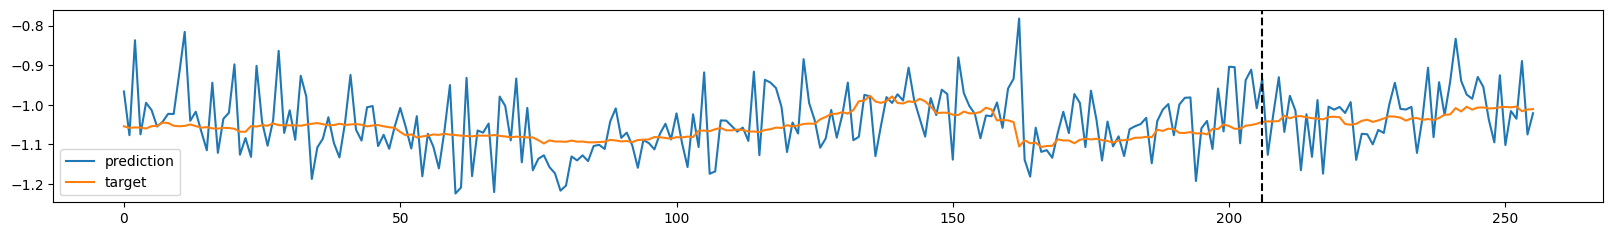

Batch:  2


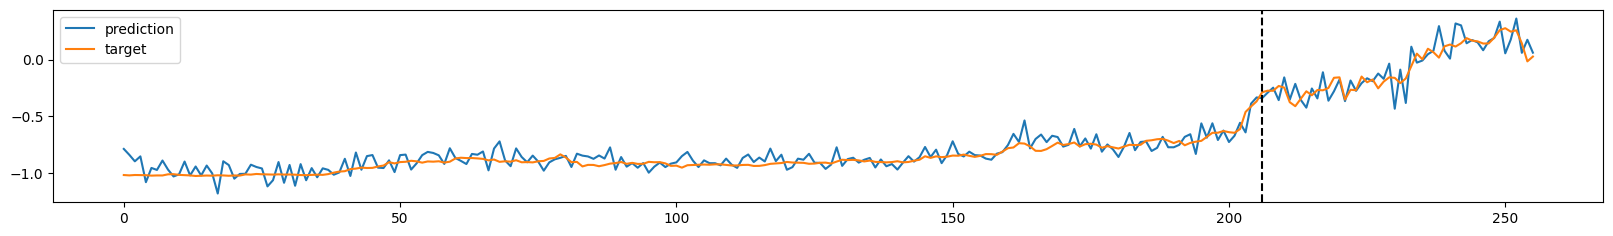

Batch:  3


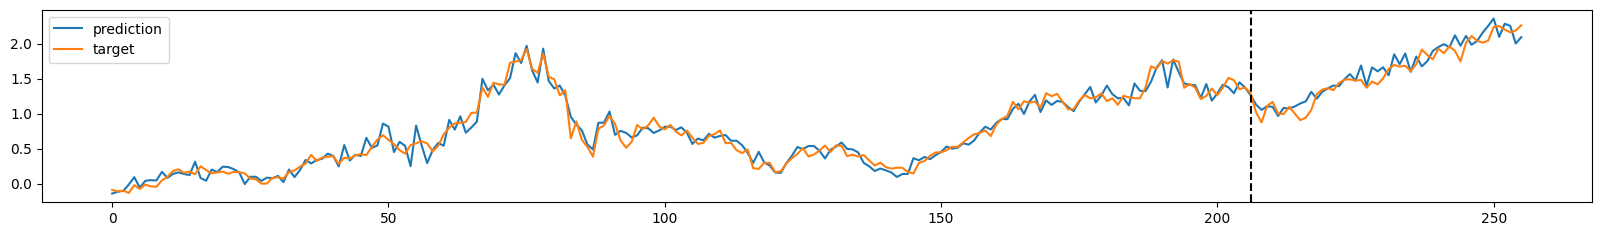

Batch:  4


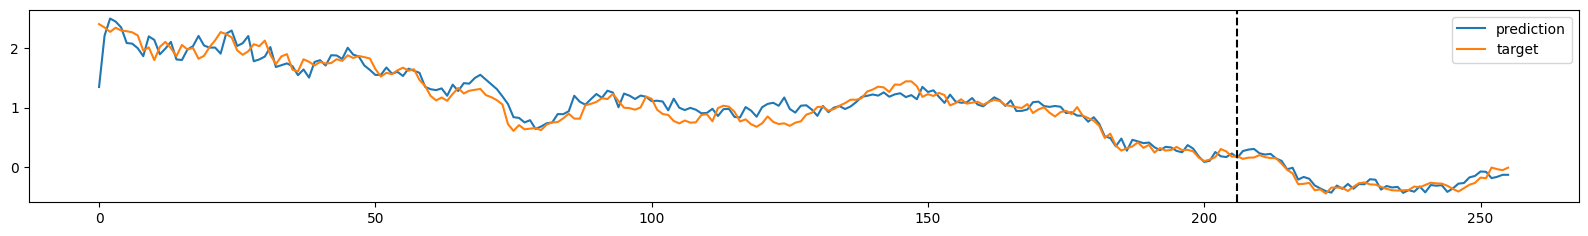

Batch:  5


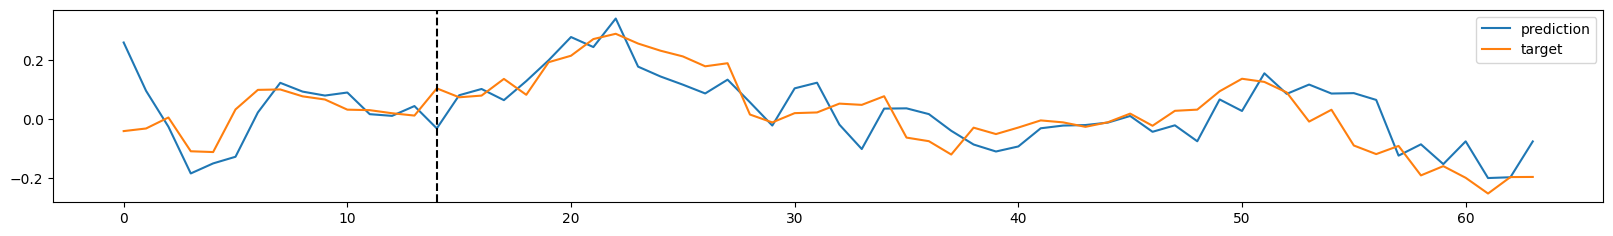

In [147]:
# make plot for the 5 batches for adj_close
for i in range(5):
    plt.figure(figsize=(20,2.5))
    stock_output_np = np.array(results[i].tolist()).squeeze(1)
    target_np = np.array(targets[i].tolist()).squeeze(1)
    # plot the target vs the prediction
    plt.plot(stock_output_np[:,0], label="prediction") 
    plt.plot(target_np[:,0], label="target") 
    # add a vertical line to indicate the end of the training data
    if i != 4:
        plt.axvline(x=206, color='k', linestyle='--')
    else:
        plt.axvline(x=14, color='k', linestyle='--')
    plt.legend()
    print("Batch: ", i+1)
    plt.show()

In [149]:
# unstadardize the data
b1 = b1*stds + means
b2 = b2*stds + means
b3 = b3*stds + means
b4 = b4*stds + means
b5 = b5*stds + means
real = real*stds + means
extra_w_np = extra_w_np*stds + means

print(b1.shape, b2.shape, b3.shape, b4.shape, b5.shape, real.shape, extra_w_np.shape)

(256, 9) (256, 9) (256, 9) (256, 9) (64, 9) (1095, 9) (7, 9)


Full prediction + forecast for adj_close, close_BTC, close_BNB and close_XRP.

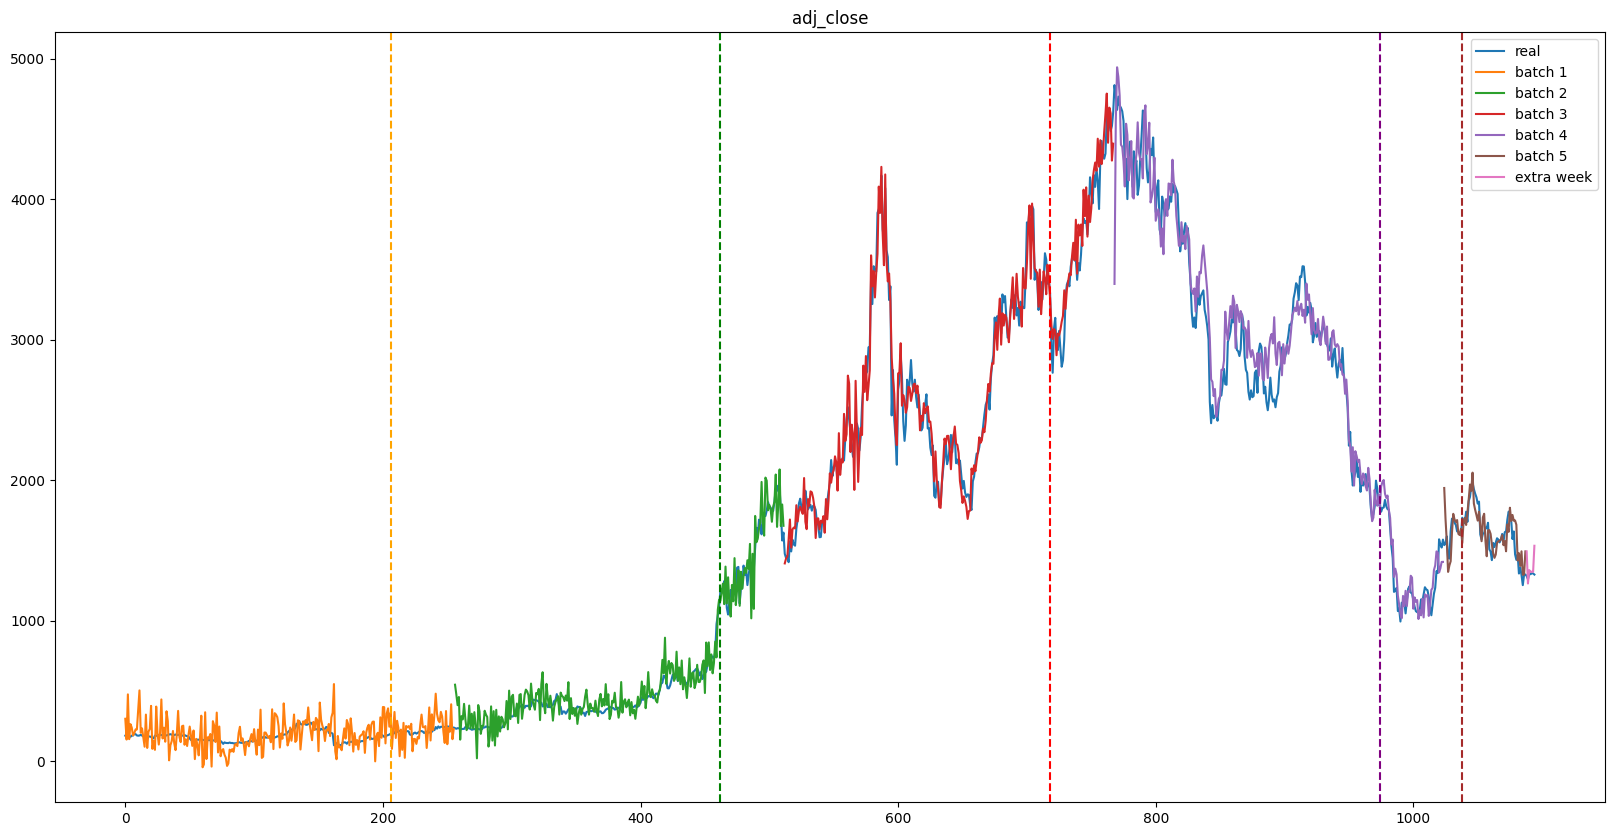

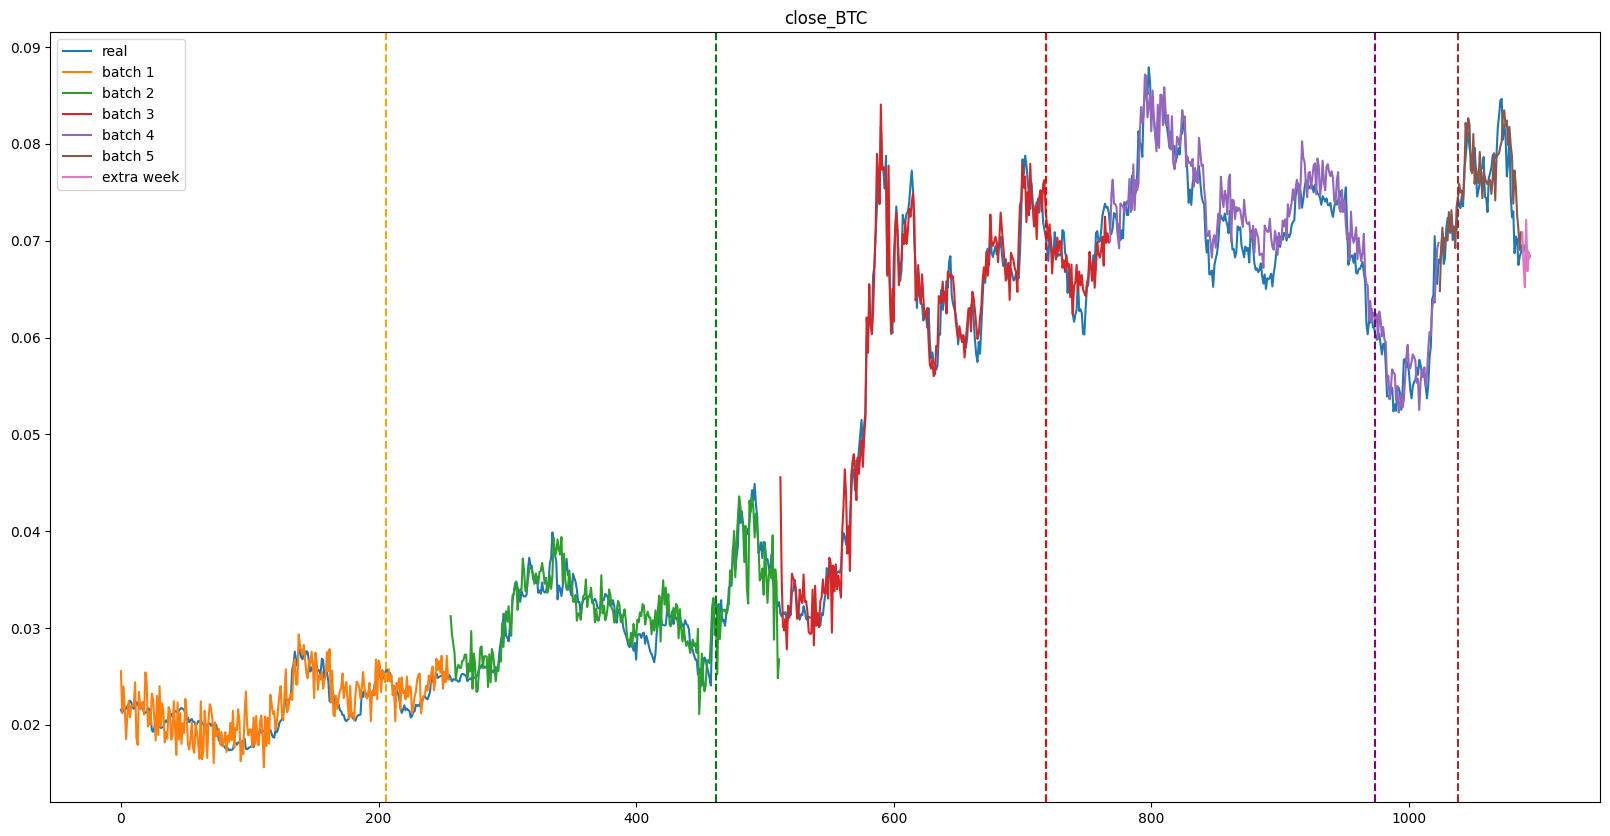

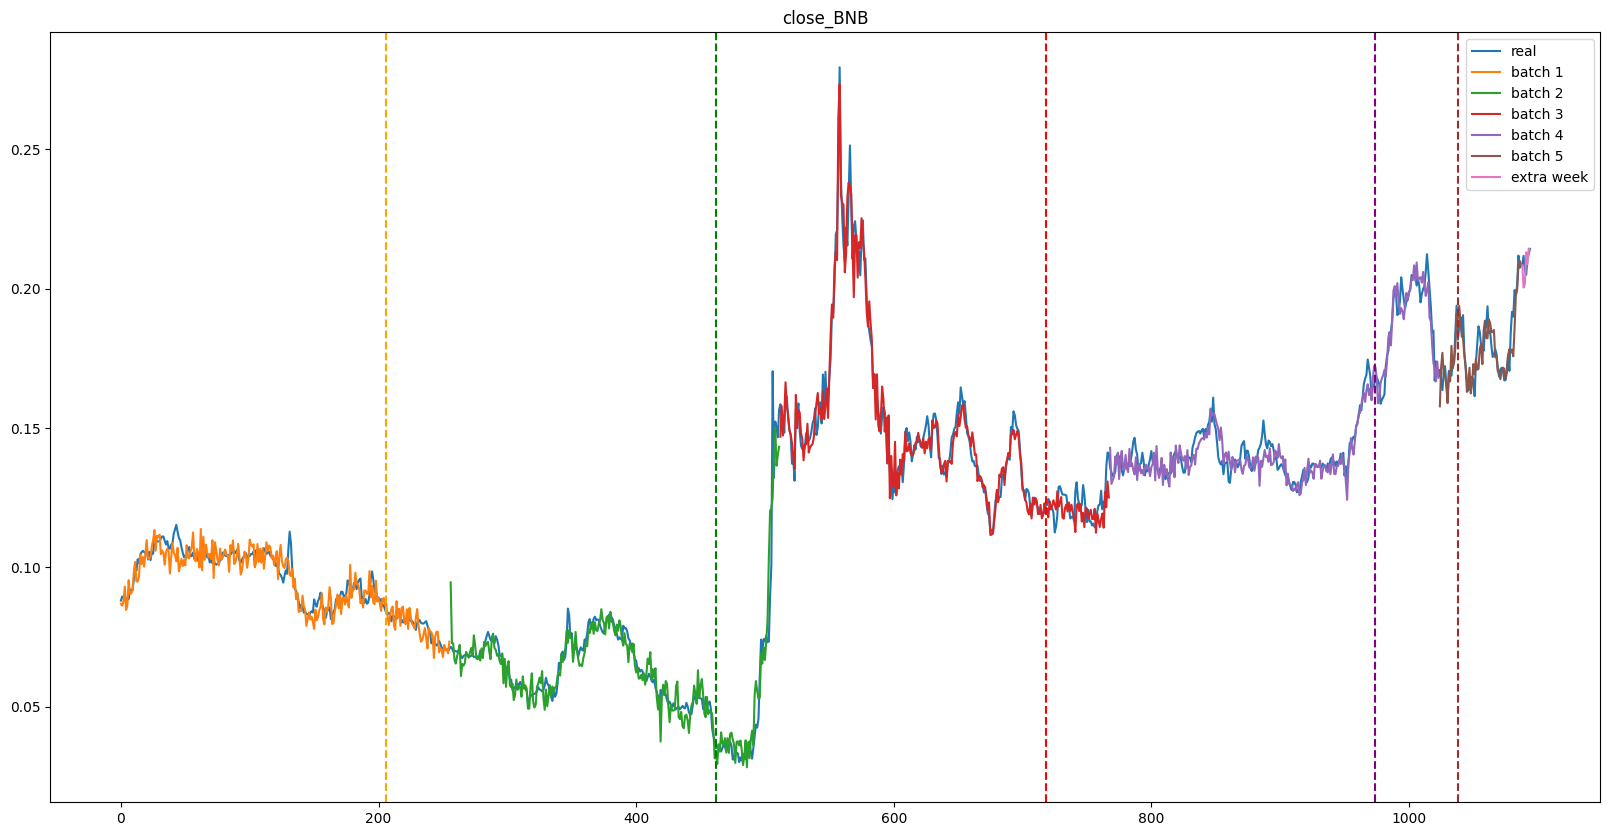

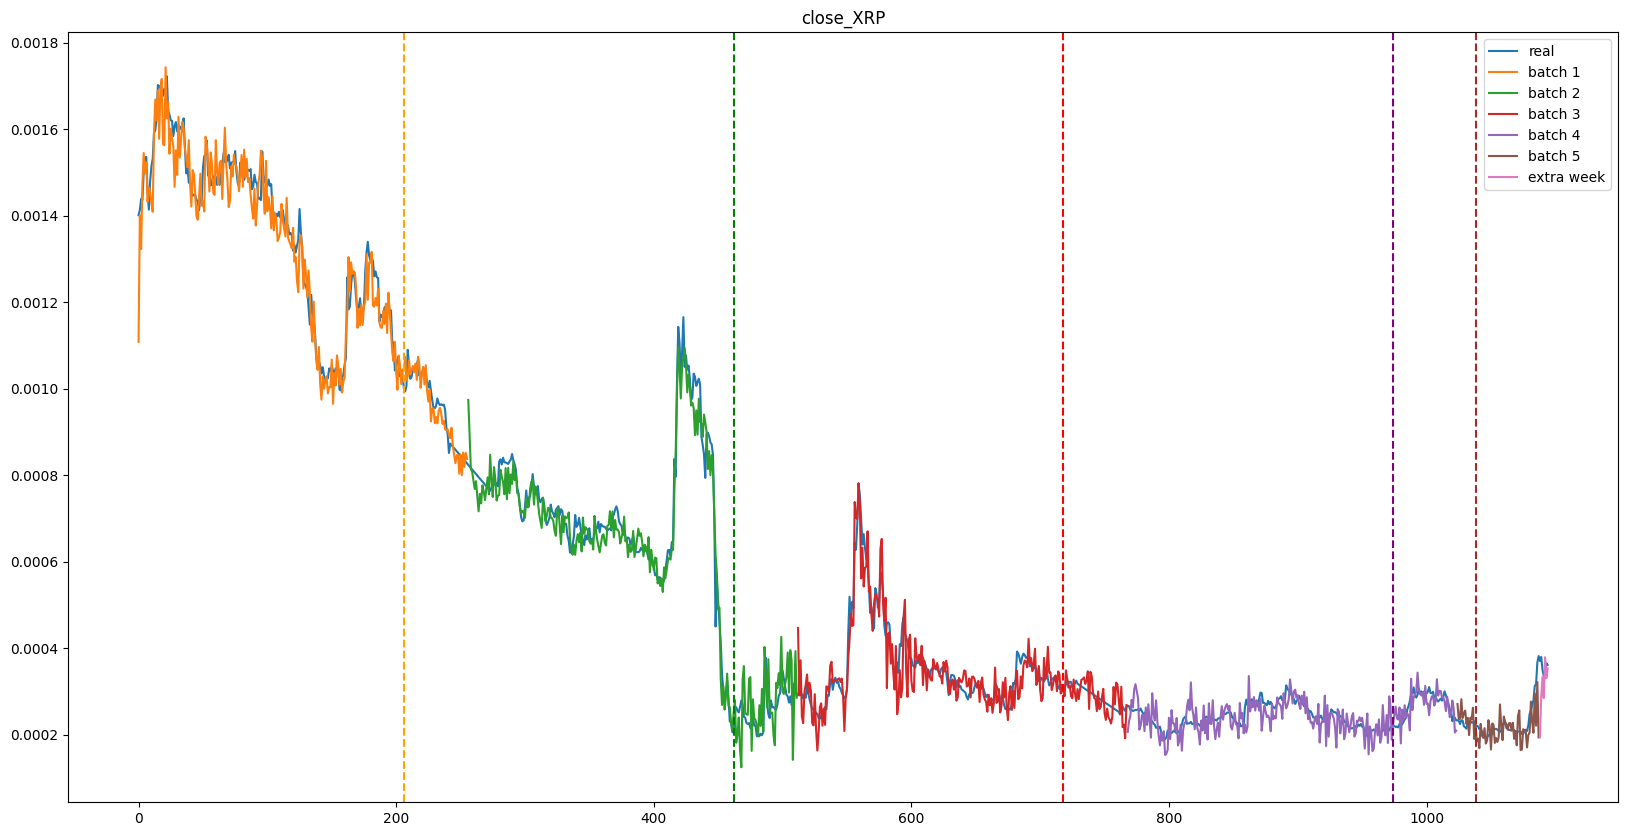

In [150]:
# put all together
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(0,1095), real[:,i], label="real")
    plt.plot(np.arange(0,256), b1[:,i], label="batch 1")
    plt.plot(np.arange(256,512), b2[:,i], label="batch 2")
    plt.plot(np.arange(512,768), b3[:,i], label="batch 3")
    plt.plot(np.arange(768,1024), b4[:,i], label="batch 4")
    plt.plot(np.arange(1024,1088), b5[:,i], label="batch 5")
    plt.plot(np.arange(1088,1095), extra_w_np[:,i], label="extra week")
    # axvline at -50 days of each batch
    plt.axvline(x=206, color='orange', linestyle='--')
    plt.axvline(x=462, color='green', linestyle='--')
    plt.axvline(x=718, color='red', linestyle='--')
    plt.axvline(x=974, color='purple', linestyle='--')
    plt.axvline(x=1038, color='brown', linestyle='--')
    plt.title(col_names[i])
    plt.legend()
    plt.show()

Zoom on the last batch + extra week forecast.

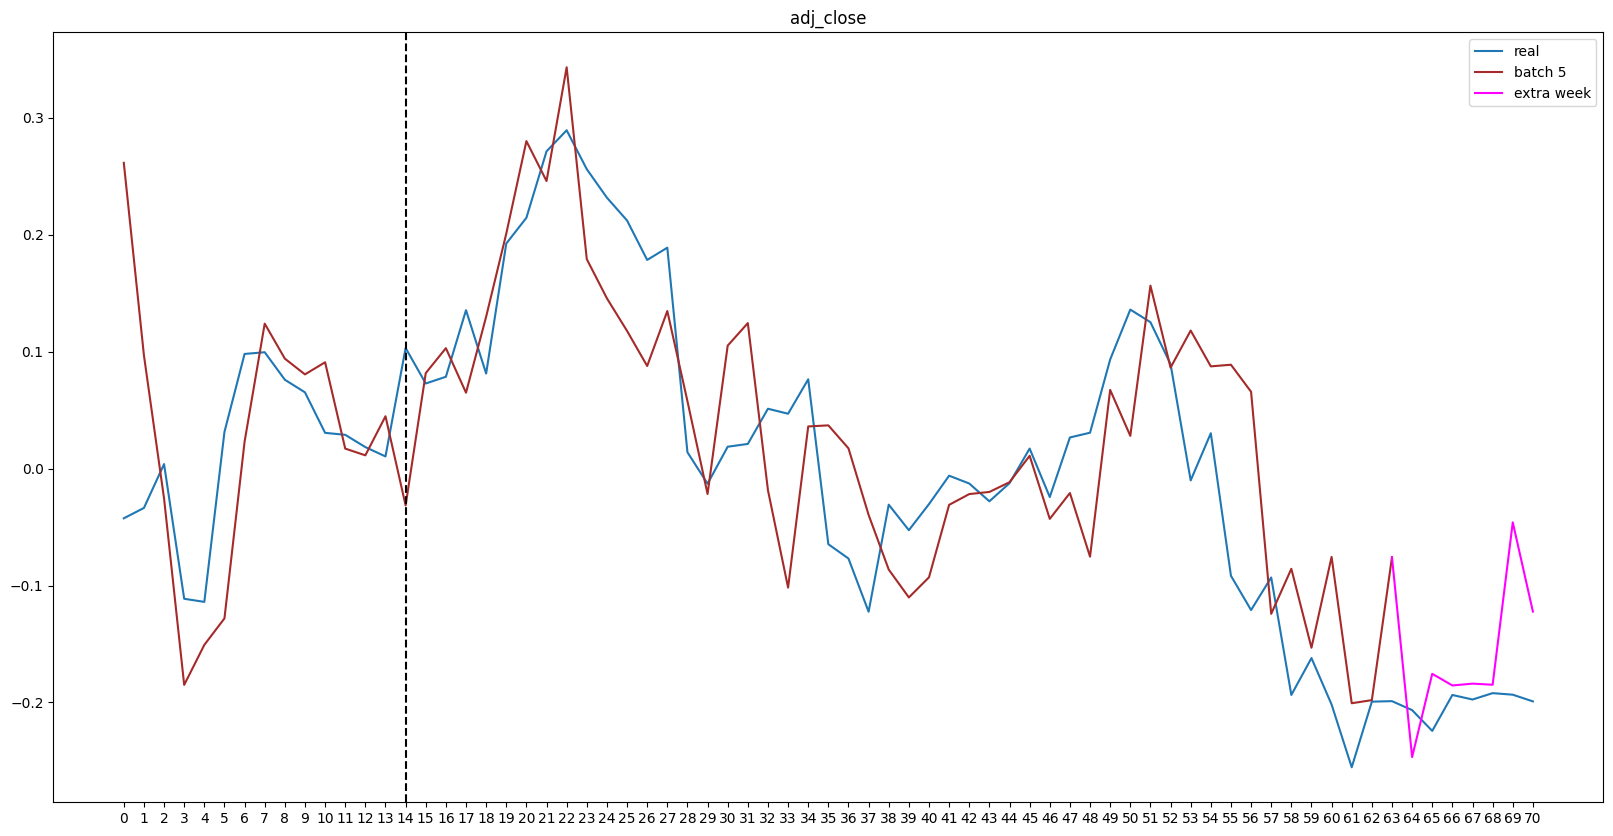

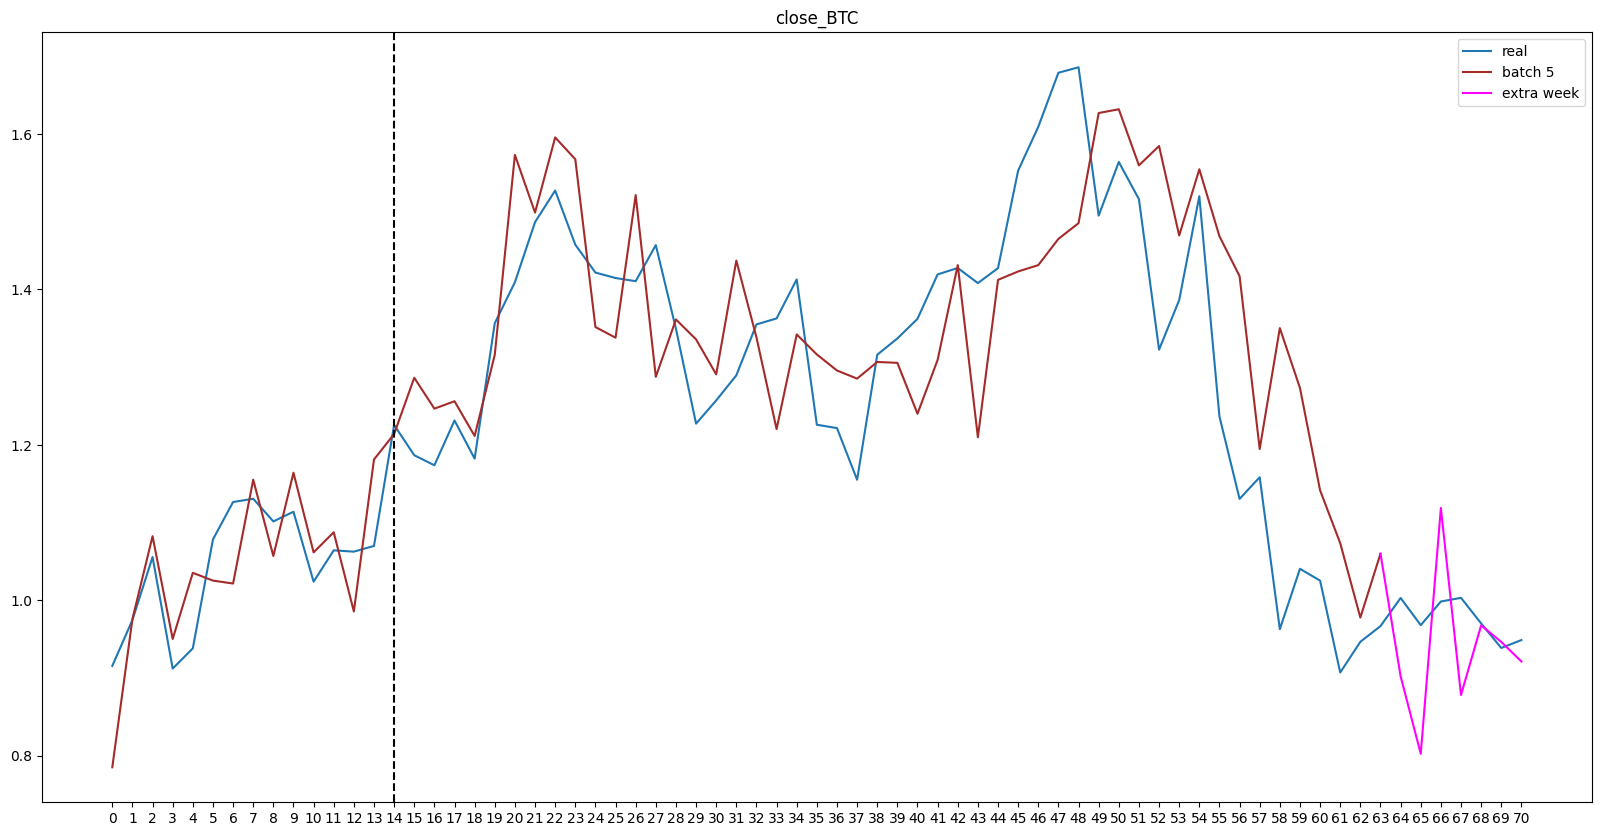

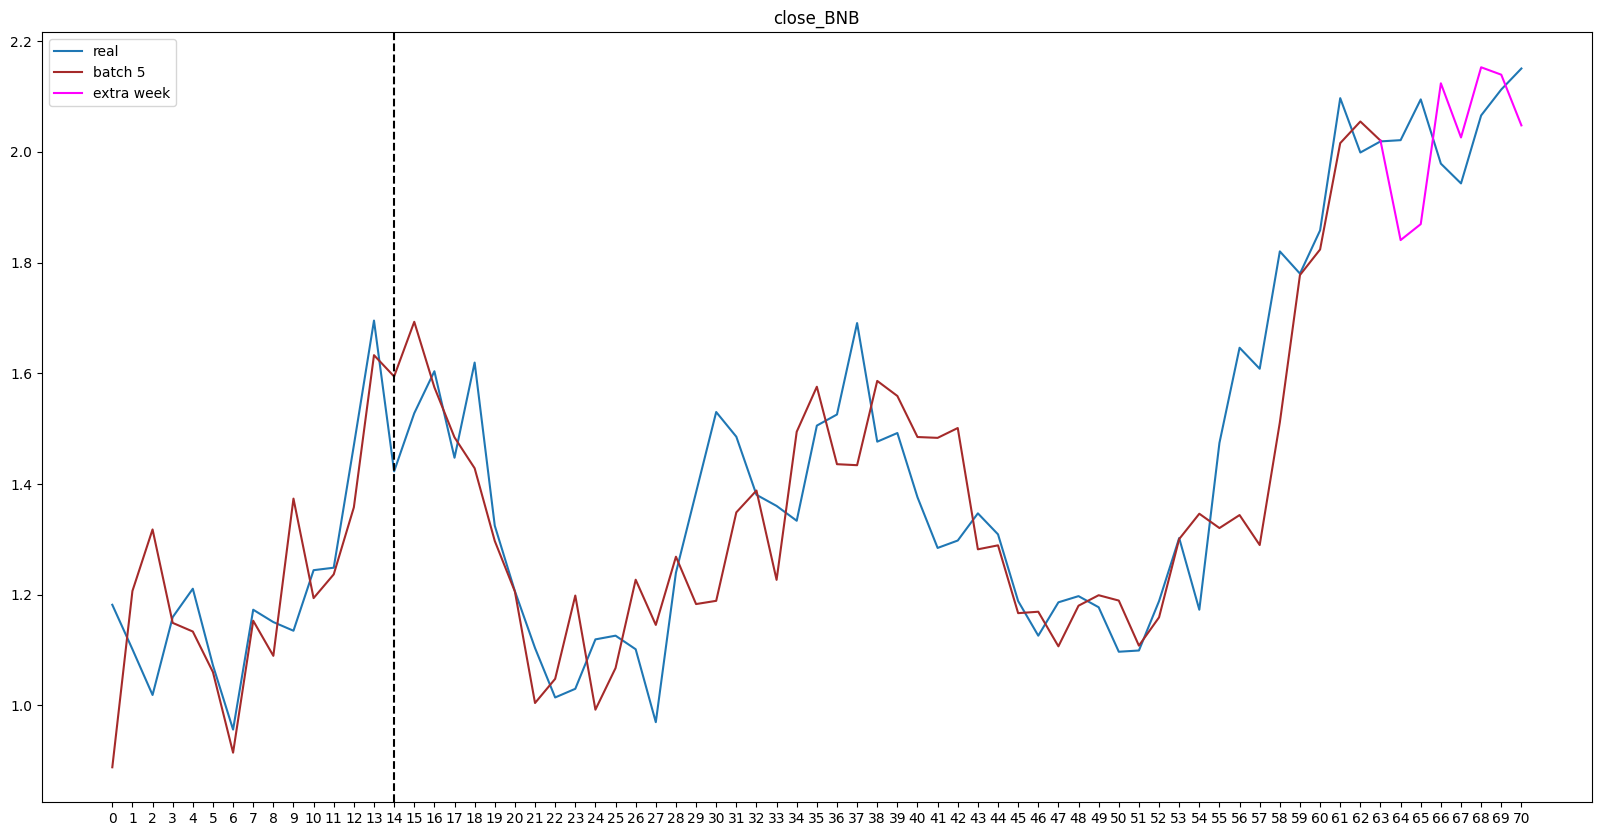

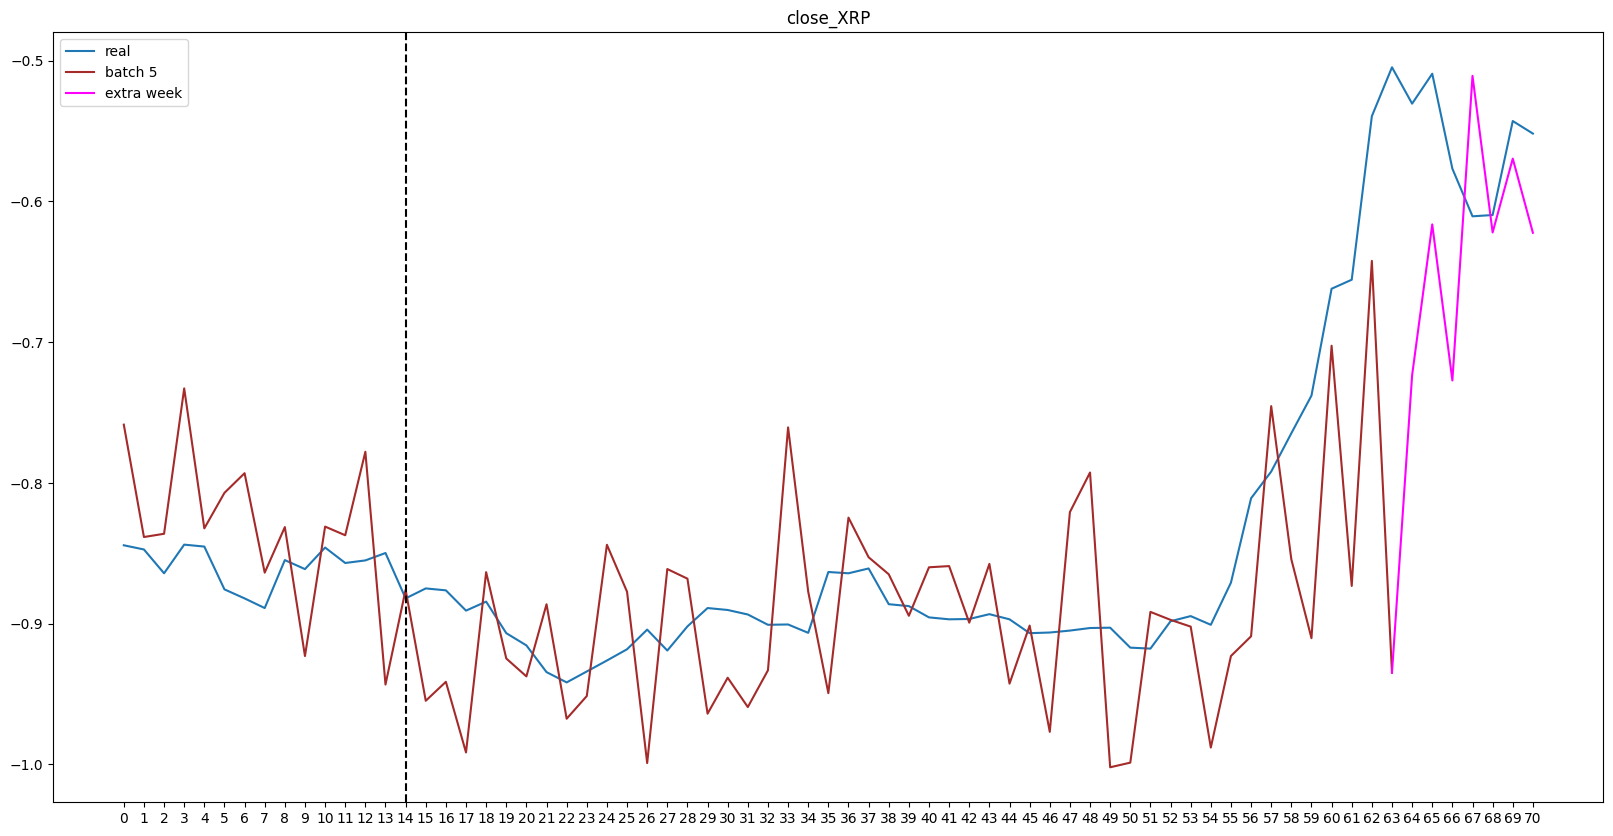

In [163]:
# plot only last batch and extra week
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,10))
    plt.plot(real[-71:,i], label="real")
    plt.plot(b5[:,i], label="batch 5", color="brown")
    plt.plot(np.arange(63,71), extra_w_np[:,i], label="extra week", color="magenta")
    plt.xticks(np.arange(0,71,1.0))
    # axvline at -50 days of each batch
    plt.axvline(x=14, color='k', linestyle='--')
    plt.title(col_names[i])
    plt.legend()
    plt.show()